### Part 2: Outlier, Transformations, Pipelines and Sanity Check

In [9]:
# Import necessary Libraries
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt   
import seaborn as sns

# The kaggle file is named heart.csv
df_heart_encoded = df_heart_encoded.copy() 
df_heart_encoded.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


### Outlier Ditection and Handing

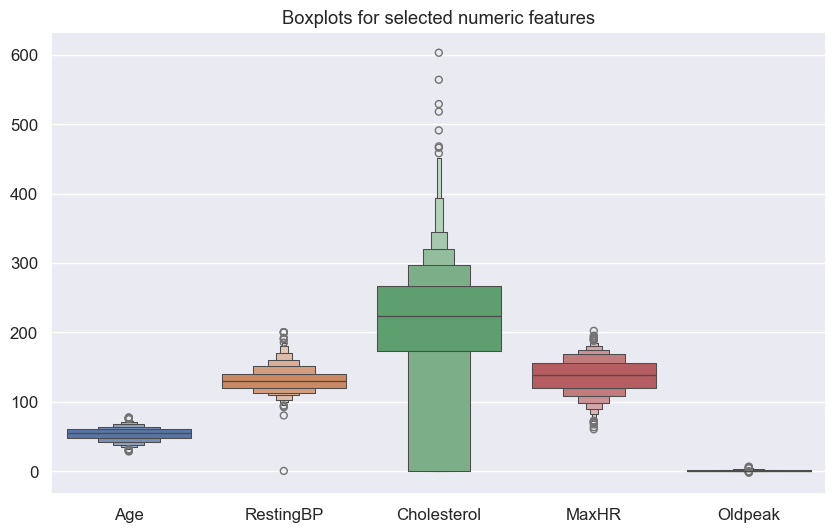

In [10]:
# Visualize some numeric collumns 
numeric_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
plt.figure(figsize=(10,6))
sns.boxenplot(data=df_heart_encoded[numeric_cols])
plt.title("Boxplots for selected numeric features")
plt.show()

In [17]:
# Using IQR method on Cholesterol as an example
col = "Cholesterol"
Q1 = df_heart_encoded[col].quantile(0.25)
Q3 = df_heart_encoded[col].quantile(0.75)
IQR = Q3-Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

outliers = df_heart_encoded[(df_heart_encoded[col] < lower) | (df_heart_encoded[col] > upper)]
print(f"Number of detected outliers in {col}: ", len(outliers))

Number of detected outliers in Cholesterol:  183


In [21]:
# 1. Remove outliers  ### this approach should not be taklen for small dataset, should be avoided in most cases
df_no_outliers = df_heart_encoded[(df_heart_encoded[col] >= lower ) & (df_heart_encoded[col] <= upper)]
print(len(df_no_outliers))

# 2. Cap outliers (winsorization-like approach)   ### this approach doesn't give actual representation of the actual dataset 
df_capped = df_heart_encoded.copy()
df_capped[col] = df_capped[col].clip(lower, upper)
print(len(df_capped))

# Log transform the column (for skewed distribution) ### this approach is better
df_log = df_heart_encoded.copy() 
df_log[col + "_log"] = np.log(df_log[col]+1)
print(df_log)

735
918
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  Cholesterol_log  
0 